In [1]:
# Import Library
#%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import keras
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

#Usare scaler

# Prepare and Review Dataset

In [2]:
# Test and Train path
with open('newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Identificare qualita' e suddivisione del dataset in maniera corretta tra train e test

 Resa bassa: 58 Resa media[4500,10000]: 1472 Resa alta(>10000): 31


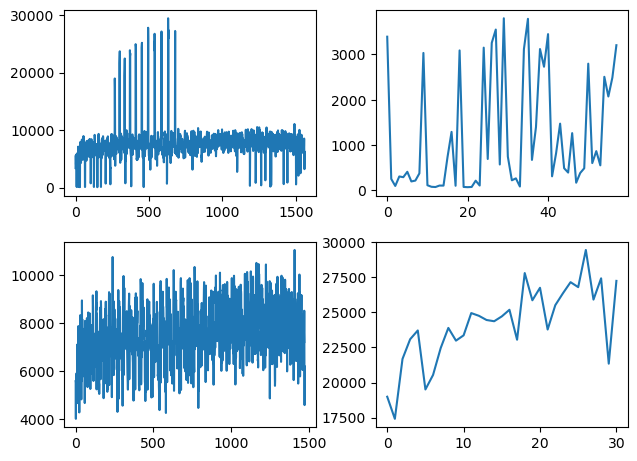

In [3]:
#taglio outliar
FilterResa3gtZero = newResa3!=0
newResa3 = newResa3[FilterResa3gtZero]
allPixel3 = allPixel3[FilterResa3gtZero,:,:]

LowValue = 1
Medium = 4000
HighValue = 12000
Resa3LowFilter = (newResa3<Medium) & (newResa3>LowValue)
Resa3MediumFilter = (newResa3>=Medium) & (newResa3<=HighValue)
Resa3HighFilter = (newResa3>HighValue)

Resa3Low = newResa3[Resa3LowFilter]
Resa3Medium = newResa3[Resa3MediumFilter]
Resa3High = newResa3[Resa3HighFilter]

Pixel3Low = allPixel3[Resa3LowFilter,:,:]
Pixel3Medium = allPixel3[Resa3MediumFilter,:,:]
Pixel3High = allPixel3[Resa3HighFilter,:,:]


print(" Resa bassa: "+str(len(Resa3Low))+ " Resa media[4500,10000]: "+ str(len(Resa3Medium))+ " Resa alta(>10000): "+ str(len(Resa3High)))

padding = 1.2
f, axarr = plt.subplots(2,2)
f.tight_layout(pad=padding)
axarr[0][0].plot(newResa3)
axarr[0][1].plot(Resa3Low)
axarr[1][0].plot(Resa3Medium)
axarr[1][1].plot(Resa3High)
plt.show()

In [4]:
Resa3Medium = Resa3Medium/Resa3Medium.max()
Pixel3Medium = Pixel3Medium/Pixel3Medium.max()

In [9]:
def ResaIdeale(ndviPicco,rumore):  
    ideale = ((ndviPicco**1.6)/2.3)+0.4
    return np.random.normal(loc=ideale, scale=rumore, size=None)

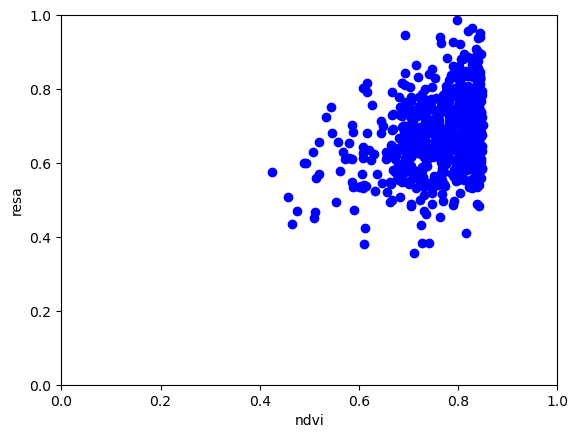

In [11]:
Resa3MediumFake = []
noise = 0.1 #standard deviation
#noise a 0.1 is very similar to original data

for v in (NVDI3Medium[:,12]):
    Resa3MediumFake.append(ResaIdeale(v,noise))

Resa3MediumFake = np.array(Resa3MediumFake)
fig, ax = plt.subplots()
ax.scatter(NVDI3Medium[:,12], Resa3MediumFake, c='blue')
ax.set_xlabel("ndvi")
ax.set_ylabel("resa")
ax.set_ylim([0,1])
ax.set_xlim([0,1])
plt.show()

# Split test set and train set

In [179]:
def splitSet(X,Y):
    if X.shape[0] != Y.shape[0]:
        raise Exception("X and Y have different sizes")
    choice = np.random.choice(range(X.shape[0]), size=(int(X.shape[0]/2),), replace=False)
    ind = np.zeros(X.shape[0], dtype=bool)
    ind[choice] = True
    rest = ~ind
    return np.array(X[ind,:,:]),np.array(Y[ind]),np.array(X[rest,:,:]),np.array(Y[rest])

[0.4654555  0.38800615 0.47504517 0.5714389  0.70085865 0.7135485
 0.7541757  0.44616774 0.70984274 0.5056399 ]


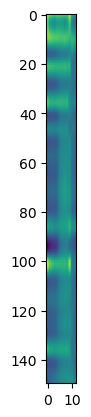

In [180]:
# Test and Train path
train_path = "dataset\\train\\"
test_path = "dataset\\test\\"

training_setMediumX,training_setMediumY, test_setMediumX, test_setMediumY = splitSet(Pixel3Medium,Resa3Medium)

training_setX = training_setMediumX
training_setY = training_setMediumY
test_setX = test_setMediumX
test_setY = test_setMediumY

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))



In [181]:
print(training_setMediumX.shape)

(736, 12, 150)


# Image augmentation

In [182]:
def multiplyImg(img):
    newImg = np.concatenate((img,img,img,img,img,img),axis = 1)
    newImg = np.stack([newImg,newImg,newImg], axis=3)
    return newImg

In [183]:
print(training_setMediumX.shape)

(736, 12, 150)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(72, 150)


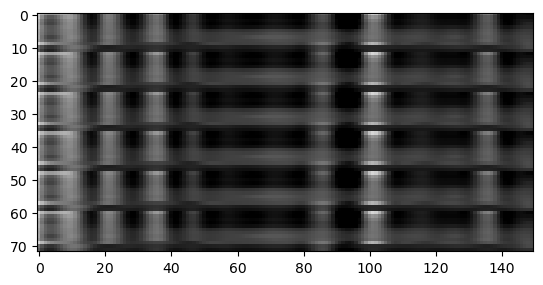

In [184]:

training_setMediumX = multiplyImg(training_setMediumX)
test_setMediumX = multiplyImg(test_setMediumX)
inputSize = training_setMediumX.shape[1:3]
print(inputSize)
plt.imshow(training_setMediumX[0])

# Creation of VGG16 model

In [185]:
# Import model
vgg16 = VGG16(input_shape=inputSize+(3,),include_top=False)


In [186]:
# add the layers of vgg16 in my created model.
vgg16Model = Sequential()
for i in range(len(vgg16.layers)-1):
    vgg16Model.add(vgg16.layers[i])


In [187]:
# Close the layers of vgg16
for layers in vgg16Model.layers:
    layers.trainable = False

In [188]:

# Last layer
vgg16Model.add(Flatten())
vgg16Model.add(Dense(2048,activation='relu',name='fc1'))
vgg16Model.add(Dense(1024,activation='relu',name='fc2'))
vgg16Model.add(Dense(1,activation='linear'))

In [189]:
# After I added last layer in created model.
vgg16Model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 72, 150, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 72, 150, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 36, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 36, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 36, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 18, 37, 256)      

In [190]:
# I create compile part.
vgg16Model.compile(loss = "mean_squared_error",
             optimizer = 'adam',
             metrics = ["mse","mae"])

# Training Model 

In [191]:
# Traning with model
batch_size = 32
#training_setMediumY, test_setMediumX, test_setMediumY
hist_vgg16 = vgg16Model.fit(x=training_setMediumX,y=training_setMediumY,
                                epochs = 25,
                                validation_data=(test_setMediumX,test_setMediumY)
                                )

Epoch 1/25
23/23 [==============================] - 76s 3s/step - loss: 1475.1853 - mse: 1475.1853 - mae: 8.9860 - val_loss: 0.3242 - val_mse: 0.3242 - val_mae: 0.5594
Epoch 2/25
23/23 [==============================] - 72s 3s/step - loss: 0.1215 - mse: 0.1215 - mae: 0.2908 - val_loss: 0.0363 - val_mse: 0.0363 - val_mae: 0.1627
Epoch 3/25
23/23 [==============================] - 71s 3s/step - loss: 0.0188 - mse: 0.0188 - mae: 0.1101 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae: 0.0913
Epoch 4/25
23/23 [==============================] - 72s 3s/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0875 - val_loss: 0.0113 - val_mse: 0.0113 - val_mae: 0.0848
Epoch 5/25
23/23 [==============================] - 72s 3s/step - loss: 0.0113 - mse: 0.0113 - mae: 0.0868 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0851
Epoch 6/25
23/23 [==============================] - 74s 3s/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0858 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0845
Epoch 7/25
23/23 [====

In [ ]:
# Save the weights of model
vgg16Model.save_weights("previsioneOttima.h5")

# Plot the result of the network

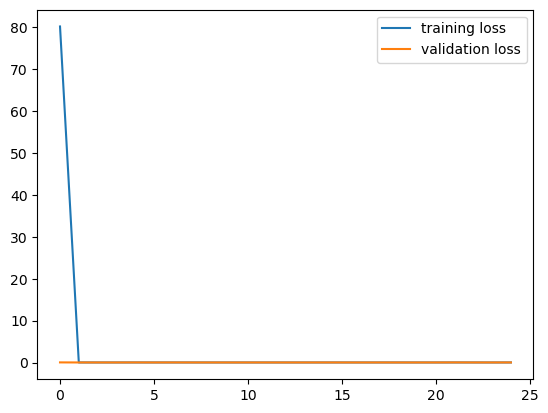

In [ ]:
# Loss and Validation Loss
plt.plot(hist_vgg16.history["loss"], label = "training loss")
plt.plot(hist_vgg16.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

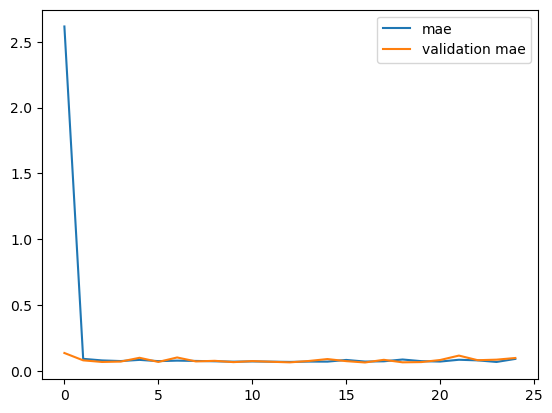

In [ ]:
# Accuracy and Validation Accuracy
plt.plot(hist_vgg16.history["mae"], label = "mae")
plt.plot(hist_vgg16.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

In [ ]:
true_y = test_setMediumY
print(len(true_y))
pred_y = vgg16Model.predict(test_setMediumX)

736
23/23 [==============================] - 13s 570ms/step


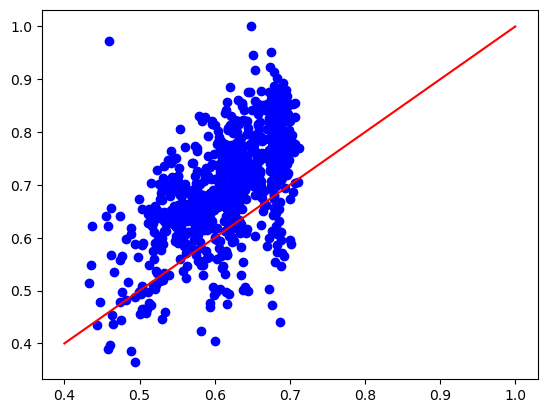

In [ ]:

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
ax.scatter(pred_y, true_y, c='blue')
line = mlines.Line2D([0.4, 1], [0.4, 1], color='red')
transform = ax.transAxes
ax.add_line(line)
plt.show()


# Save the result

In [396]:
import json, codecs
with open("previsioneResa.json","w") as f:
    json.dump(hist_vgg16.history, f)

In [152]:
'''with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())'''

'with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:\n    load_result = json.loads(f.read())'

# Vgg19

In [397]:
# Import VGG19 model
vgg19 = VGG19(input_shape=inputSize+(3,),include_top=False)

In [398]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 36, 60, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 36, 60, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 36, 60, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 18, 30, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 18, 30, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 18, 30, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 9, 15, 128)        0     

In [400]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
vgg19Model.add(vgg19)

In [401]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [405]:
# Last layer
vgg19Model.add(Flatten())
vgg16Model.add(Dense(2048,activation='relu',name='fc1'))
vgg16Model.add(Dense(1024,activation='relu',name='fc2'))
vgg19Model.add(Dense(1,activation='linear'))

In [406]:
# the final version of the model
vgg19Model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_16 (Flatten)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 4096)              2101248   
                                                                 
 dense_23 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_24 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_25 (Dense)            (None, 512)               524800    
                                                                 
 dense_26 (Dense)            (None, 256)             

In [407]:
# compile the model
vgg19Model.compile(loss = "mean_squared_error",
             optimizer = "adam",
             metrics = ["mse","mae"])

# Training

In [409]:
# Training with my created model
hisy_vgg19 = vgg19Model.fit(x=training_setMediumX,y=training_setMediumY,
                                epochs = 30,
                                validation_data=(test_setMediumX,test_setMediumY)
                               )

Epoch 1/30
11/11 [==============================] - 6s 437ms/step - loss: 0.3168 - mse: 0.3168 - mae: 0.4777 - val_loss: 0.1893 - val_mse: 0.1893 - val_mae: 0.4124
Epoch 2/30
11/11 [==============================] - 4s 407ms/step - loss: 0.0463 - mse: 0.0463 - mae: 0.1601 - val_loss: 0.1118 - val_mse: 0.1118 - val_mae: 0.3078
Epoch 3/30
11/11 [==============================] - 4s 420ms/step - loss: 0.0361 - mse: 0.0361 - mae: 0.1546 - val_loss: 0.0423 - val_mse: 0.0423 - val_mae: 0.1704
Epoch 4/30
11/11 [==============================] - 4s 415ms/step - loss: 0.0252 - mse: 0.0252 - mae: 0.1303 - val_loss: 0.0324 - val_mse: 0.0324 - val_mae: 0.1470
Epoch 5/30
11/11 [==============================] - 5s 427ms/step - loss: 0.0197 - mse: 0.0197 - mae: 0.1123 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.1010
Epoch 6/30
11/11 [==============================] - 5s 443ms/step - loss: 0.0195 - mse: 0.0195 - mae: 0.1116 - val_loss: 0.0120 - val_mse: 0.0120 - val_mae: 0.0900
Epoch 7/30
11/11

# Plot the result of the network

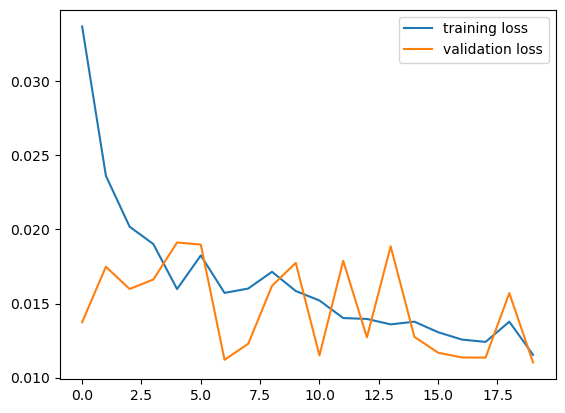

In [ ]:
# Loss And Validation Loss
plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

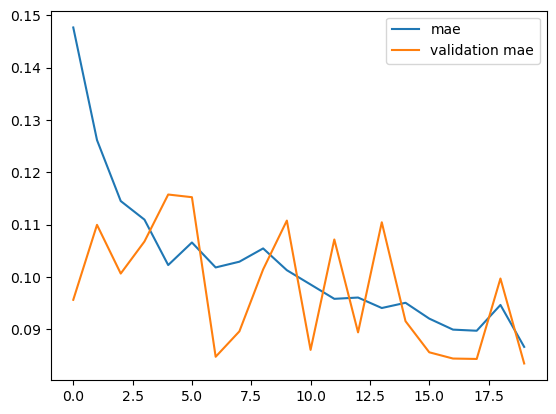

In [ ]:
# Accuracy And Validation Accuracy
plt.plot(hisy_vgg19.history["mae"], label = "mae")
plt.plot(hisy_vgg19.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

In [410]:
true_y = test_setMediumY
print(len(true_y)) 
pred_y = vgg19Model.predict(test_setMediumX)

321
11/11 [==============================] - 2s 156ms/step


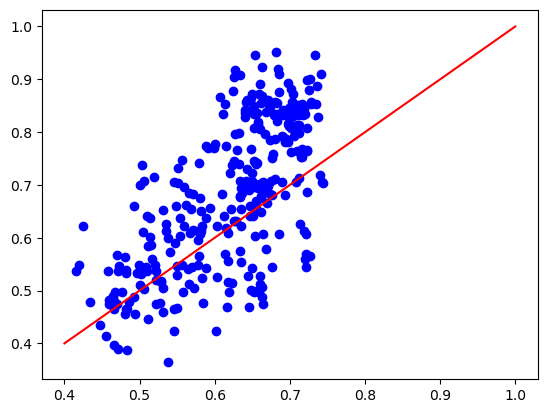

In [411]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

#
#lineStart = data_calc_hourly.temp.min() 
#lineEnd = data_calc_hourly.temp.max()  
fig, ax = plt.subplots()
ax.scatter(pred_y, true_y, c='blue')
line = mlines.Line2D([0.4, 1], [0.4, 1], color='red')
transform = ax.transAxes
#line.set_transform(transform)
ax.add_line(line)
plt.show()                      

In [412]:
# Save the weights of model
vgg19Model.save_weights("previsioneOttimavgg19.h5")
import json, codecs
with open("previsioneResavgg19.json","w") as f:
    json.dump(hisy_vgg19.history, f)